In [2]:
from narxpy import NARX
import torch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

In [6]:
script_dir = os.getcwd()
data_file_path = os.path.join(script_dir, "data", "maglev_data.csv")

df = pd.read_csv(data_file_path, header = None, names = ["current", "position"])
df

,current,position
0,3.750646,0.500000
1,3.750646,0.506442
2,3.750646,0.525258
3,3.750646,0.555481
4,3.750646,0.595958
...,...,...
3996,1.199622,2.865977
3997,1.199622,2.860937
3998,1.199622,2.855380
3999,1.199622,2.849327


In [7]:
current_numpy = df["current"].to_numpy()
position_numpy = df["position"].to_numpy()

# scaling 
current_scaler = MinMaxScaler(feature_range=(0, 1))
position_scaler = MinMaxScaler(feature_range=(0, 1))

current_tensor = torch.tensor(
    current_scaler.fit_transform(current_numpy.reshape(-1, 1)),
    dtype=torch.float32
).unsqueeze(0) 

position_tensor = torch.tensor(
    position_scaler.fit_transform(position_numpy.reshape(-1, 1)), 
    dtype=torch.float32
).unsqueeze(0) 


print("Scaled Tensor Shapes:")
print(current_tensor.shape)
print(position_tensor.shape)

Scaled Tensor Shapes:
torch.Size([1, 4001, 1])
torch.Size([1, 4001, 1])


In [8]:
# train, validation, test
train_prop = 0.6
valid_prop = 0.2

sequence_length = current_tensor.shape[1]
n_train = int(train_prop * sequence_length)
n_val = int(valid_prop * sequence_length)
n_test = sequence_length - n_train - n_val 

split1 = n_train
split2 = n_train + n_val

# Training Set
train_current = current_tensor[:, :split1, :]
train_position = position_tensor[:, :split1, :]

# Validation Set
valid_current = current_tensor[:, split1:split2, :]
valid_position = position_tensor[:, split1:split2, :]

# Test Set
test_current = current_tensor[:, split2:, :]
test_position = position_tensor[:, split2:, :]

# PARALLEL TRAIN ARCHITECTURE

In [9]:
model = NARX(d_i = 30, d_o = 30, d_x = 1, d_y = 1, d_hl = 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr = 0.001, params = model.parameters())

EPOCHS = 1000
PATIENCE = 5

best_MSE = None
patience = None

train_loss_history = []
valid_loss_history = []

for i in range(EPOCHS):
    # training
    model.train()
    y_pred = model(train_current)
    loss = loss_fn(train_position, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_history.append(loss.item())

    # validation
    model.eval()
    with torch.no_grad():
        y_pred = model(valid_current)
        loss = loss_fn(valid_position, y_pred)

        print(f"BCE validation loss at epoch {i}: {loss.item()}")
        valid_loss_history.append(loss.item())

        if best_MSE is None or loss.item() < best_MSE:
            best_MSE = loss.item()
            patience = PATIENCE
        
        else:
            patience -= 1
            if patience == 0:
                break

BCE validation loss at epoch 0: 0.09283097088336945
BCE validation loss at epoch 1: 0.0923939123749733
BCE validation loss at epoch 2: 0.09198445081710815
BCE validation loss at epoch 3: 0.09160108864307404
BCE validation loss at epoch 4: 0.09124234318733215
BCE validation loss at epoch 5: 0.09090709686279297
BCE validation loss at epoch 6: 0.09059444069862366
BCE validation loss at epoch 7: 0.09030355513095856
BCE validation loss at epoch 8: 0.090033620595932
BCE validation loss at epoch 9: 0.08978386223316193
BCE validation loss at epoch 10: 0.08955343067646027
BCE validation loss at epoch 11: 0.08934154361486435
BCE validation loss at epoch 12: 0.08914737403392792
BCE validation loss at epoch 13: 0.08897005021572113
BCE validation loss at epoch 14: 0.08880868554115295
BCE validation loss at epoch 15: 0.08866236358880997
BCE validation loss at epoch 16: 0.08853016048669815
BCE validation loss at epoch 17: 0.08841106295585632
BCE validation loss at epoch 18: 0.0883040502667427
BCE val

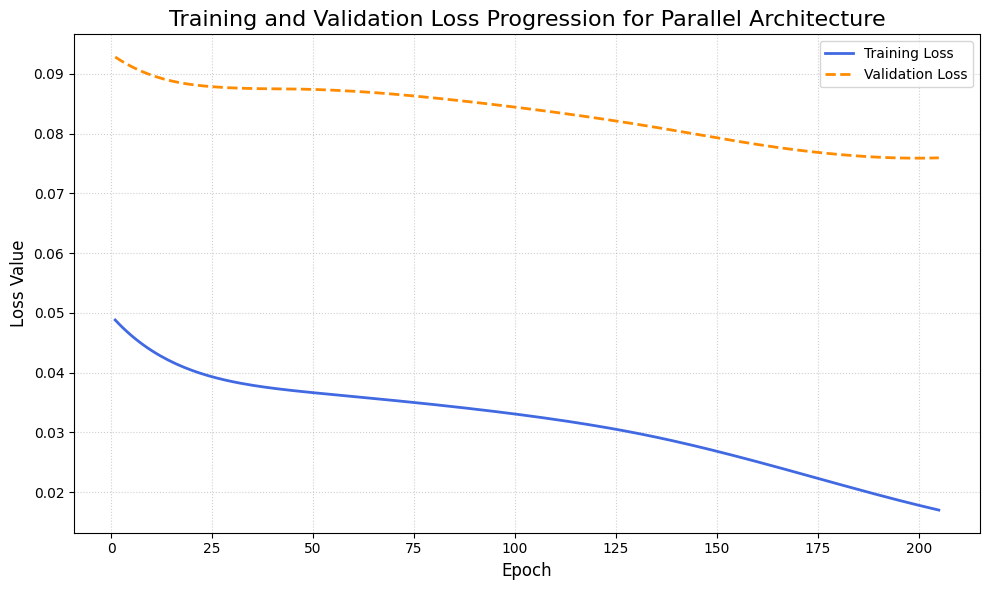

In [10]:
num_epochs = len(train_loss_history)
epoch_axis = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epoch_axis, train_loss_history, label='Training Loss', color='royalblue', linewidth=2)
plt.plot(epoch_axis, valid_loss_history, label='Validation Loss', color='darkorange', linestyle='--', linewidth=2)

plt.title('Training and Validation Loss Progression for Parallel Architecture', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

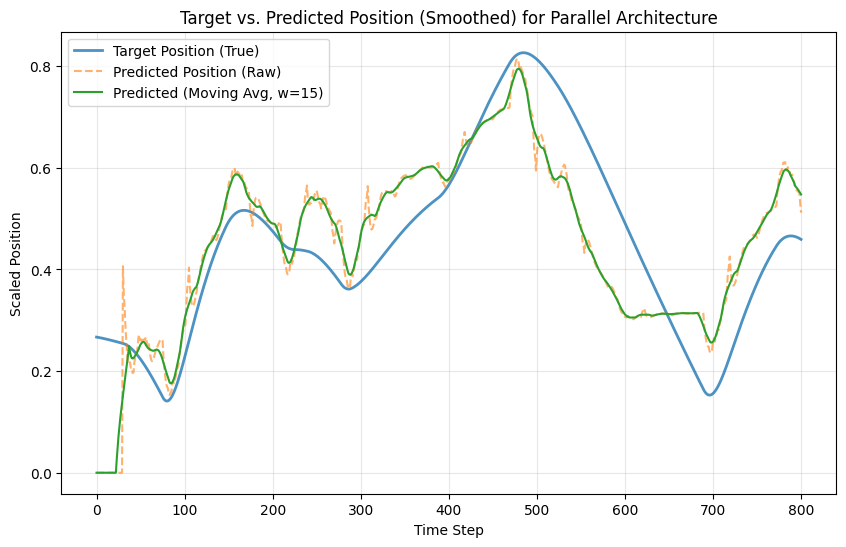

In [11]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    y_pred = model(test_current) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# SERIES-PARALLEL TRAIN ARCHITECTURE

In [17]:
model = NARX(d_i = 30, d_o = 30, d_x = 1, d_y = 1, d_hl = 16)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr = 0.01, params = model.parameters())

EPOCHS = 1000
PATIENCE = 5

best_MSE = None
patience = None

train_loss_history = []
valid_loss_history = []

for i in range(EPOCHS):
    # training
    model.train()
    y_pred = model.forward(x=train_current, mode = "open", y=train_position)
    loss = loss_fn(train_position, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_history.append(loss.item())

    # validation
    model.eval()
    with torch.no_grad():
        y_pred = model(x=valid_current,  mode = "open", y=valid_position)
        loss = loss_fn(valid_position, y_pred)

        print(f"BCE validation loss at epoch {i}: {loss.item()}")
        valid_loss_history.append(loss.item())

        if best_MSE is None or loss.item() < best_MSE:
            best_MSE = loss.item()
            patience = PATIENCE
        
        else:
            patience -= 1
            if patience == 0:
                break

BCE validation loss at epoch 0: 0.08326849341392517
BCE validation loss at epoch 1: 0.07672417163848877
BCE validation loss at epoch 2: 0.0716167762875557
BCE validation loss at epoch 3: 0.06903958320617676
BCE validation loss at epoch 4: 0.06703829765319824
BCE validation loss at epoch 5: 0.06343569606542587
BCE validation loss at epoch 6: 0.06037208437919617
BCE validation loss at epoch 7: 0.05826305225491524
BCE validation loss at epoch 8: 0.056698571890592575
BCE validation loss at epoch 9: 0.05431503802537918
BCE validation loss at epoch 10: 0.05087685585021973
BCE validation loss at epoch 11: 0.04770723730325699
BCE validation loss at epoch 12: 0.04522959142923355
BCE validation loss at epoch 13: 0.043244343250989914
BCE validation loss at epoch 14: 0.04130124673247337
BCE validation loss at epoch 15: 0.03894294798374176
BCE validation loss at epoch 16: 0.03677864372730255
BCE validation loss at epoch 17: 0.03498868644237518
BCE validation loss at epoch 18: 0.033388592302799225
B

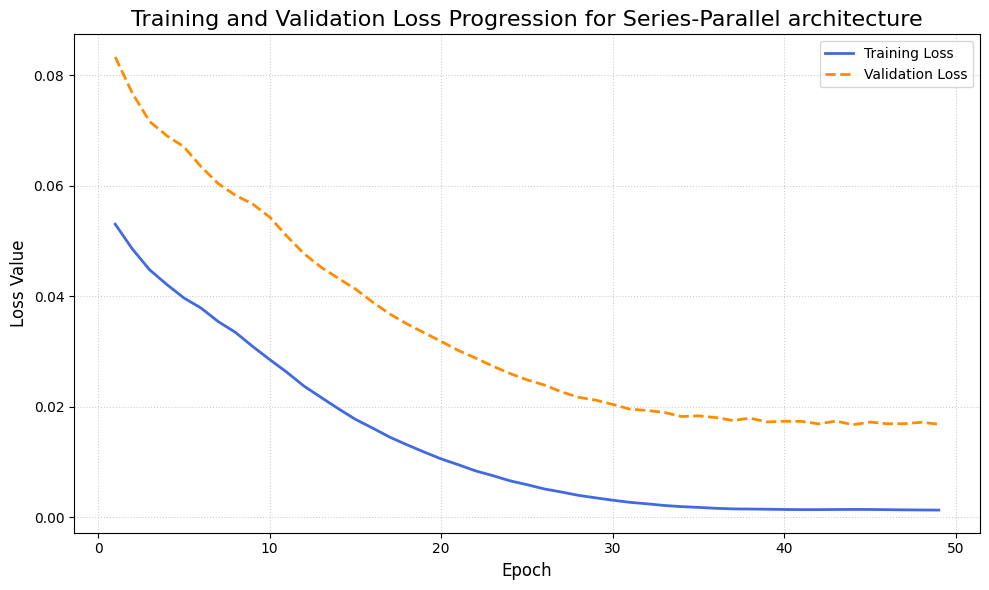

In [18]:
num_epochs = len(train_loss_history)
epoch_axis = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epoch_axis, train_loss_history, label='Training Loss', color='royalblue', linewidth=2)
plt.plot(epoch_axis, valid_loss_history, label='Validation Loss', color='darkorange', linestyle='--', linewidth=2)

plt.title('Training and Validation Loss Progression for Series-Parallel architecture', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

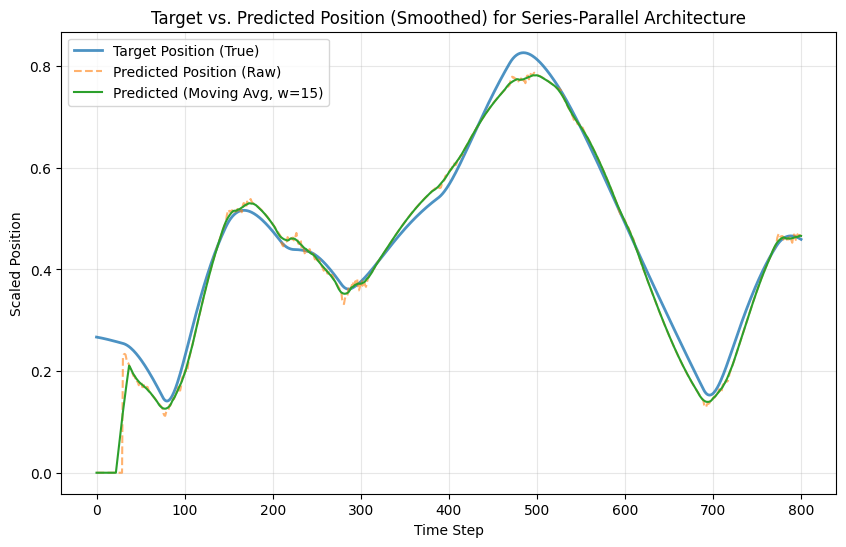

In [20]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    y_pred = model(x = test_current, mode="open", y = test_position) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Series-Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

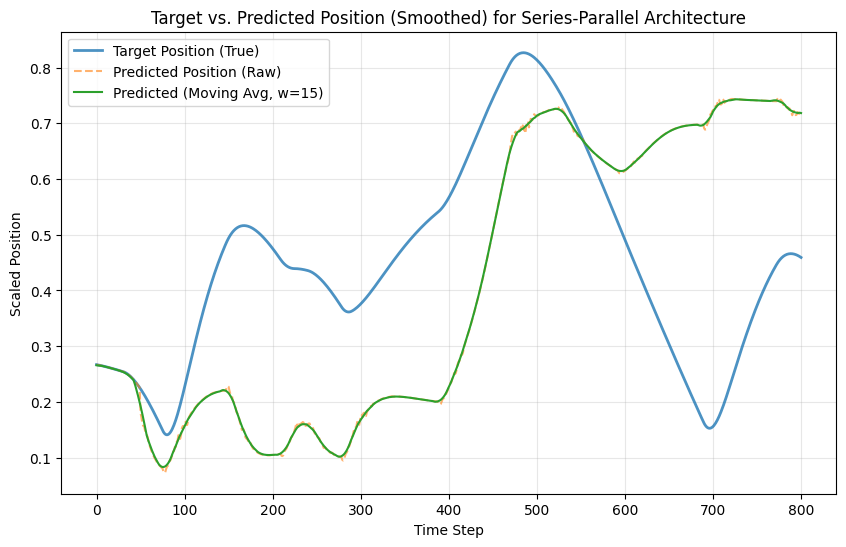

In [21]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    y_pred = model(test_current, y = test_position, bootstrap = 50) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Series-Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

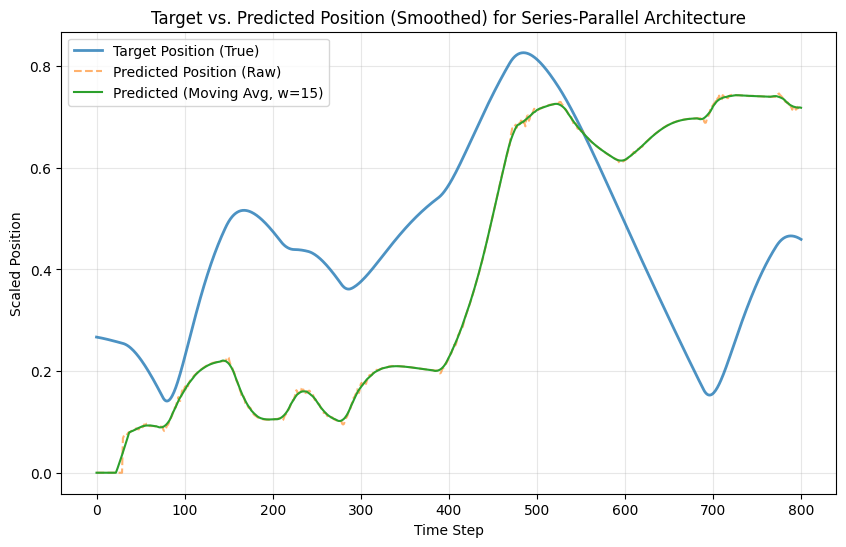

In [22]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    y_pred = model(test_current) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Series-Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# GRU COMPARISON #

In [23]:
class GRUModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, h2, p_dropout):
        super().__init__()
        self.GRU = torch.nn.GRU(input_size = input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear1 = torch.nn.Linear(hidden_size, h2)
        self.linear2 = torch.nn.Linear(h2, 1)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(p=p_dropout)
        
    def forward(self, x):
        x, _ = self.GRU(x)      
        x = self.dropout(x)
        x = self.linear1(x)     
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)  
        x = self.act2(x)
        return x
    
x = torch.rand(2,2,3)
trial_mod = GRUModel(input_size=3, hidden_size=6, num_layers=3, h2=4, p_dropout=0.2)
y = trial_mod(x)
print(y.shape)

torch.Size([2, 2, 1])


In [24]:
model = GRUModel(input_size=1, hidden_size=64, num_layers=1, h2=16, p_dropout=0.2)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lr = 0.005, params = model.parameters())

EPOCHS = 1000
PATIENCE = 5

best_MSE = None
patience = None

train_loss_history = []
valid_loss_history = []

for i in range(EPOCHS):
    # training
    model.train()
    y_pred = model(train_current)
    loss = loss_fn(train_position, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_history.append(loss.item())

    # validation
    model.eval()
    with torch.no_grad():
        y_pred = model(valid_current)
        loss = loss_fn(valid_position, y_pred)

        print(f"BCE validation loss at epoch {i}: {loss.item()}")
        valid_loss_history.append(loss.item())

        if best_MSE is None or loss.item() < best_MSE:
            best_MSE = loss.item()
            patience = PATIENCE
        
        else:
            patience -= 1
            if patience == 0:
                break

BCE validation loss at epoch 0: 0.08115085959434509
BCE validation loss at epoch 1: 0.08079777657985687
BCE validation loss at epoch 2: 0.08052365481853485
BCE validation loss at epoch 3: 0.08020605146884918
BCE validation loss at epoch 4: 0.07975171506404877
BCE validation loss at epoch 5: 0.0791807472705841
BCE validation loss at epoch 6: 0.07855135202407837
BCE validation loss at epoch 7: 0.0766761377453804
BCE validation loss at epoch 8: 0.06703458726406097
BCE validation loss at epoch 9: 0.04300156980752945
BCE validation loss at epoch 10: 0.13537809252738953
BCE validation loss at epoch 11: 0.0663219466805458
BCE validation loss at epoch 12: 0.06679266691207886
BCE validation loss at epoch 13: 0.07297863811254501
BCE validation loss at epoch 14: 0.07307274639606476


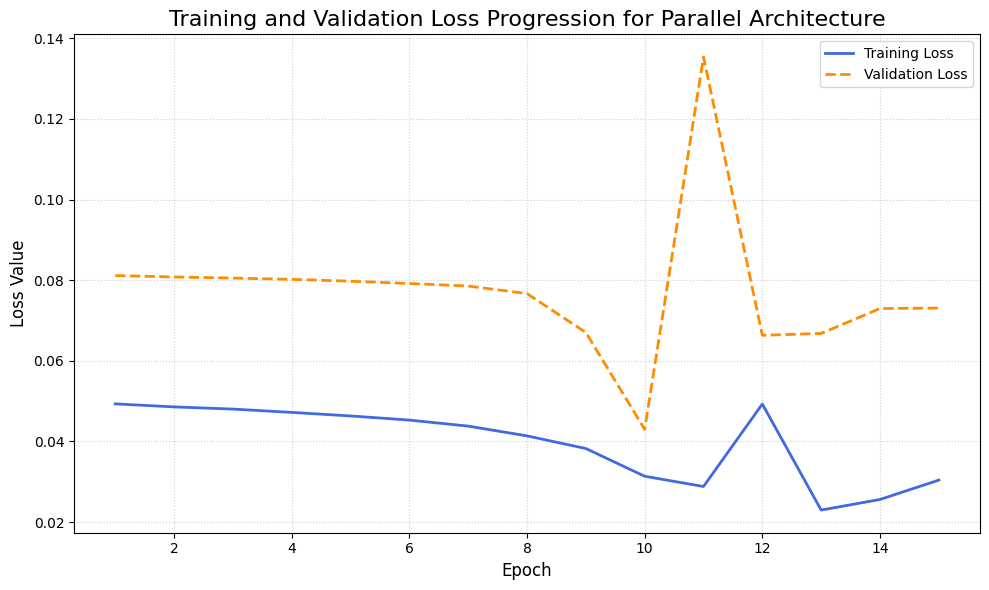

In [25]:
num_epochs = len(train_loss_history)
epoch_axis = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))

plt.plot(epoch_axis, train_loss_history, label='Training Loss', color='royalblue', linewidth=2)
plt.plot(epoch_axis, valid_loss_history, label='Validation Loss', color='darkorange', linestyle='--', linewidth=2)

plt.title('Training and Validation Loss Progression for Parallel Architecture', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

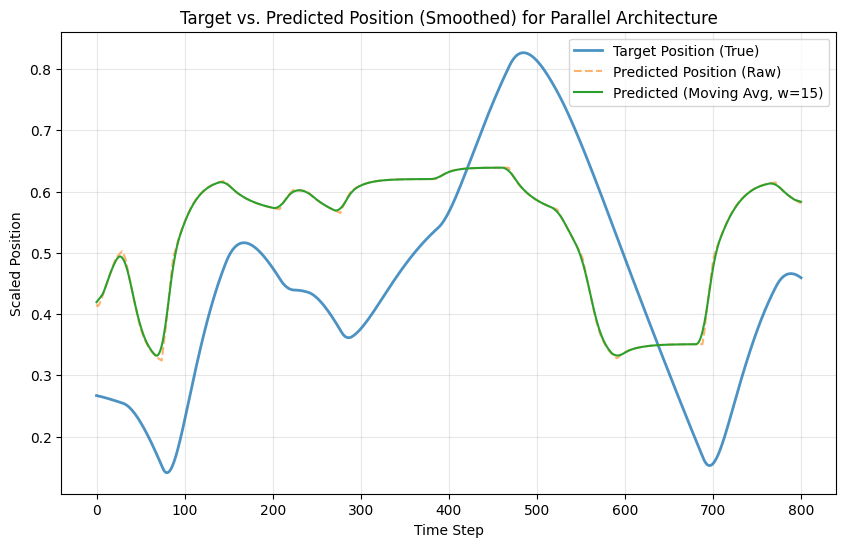

In [26]:
import torch
import matplotlib.pyplot as plt
import pandas as pd 

with torch.no_grad():
    model.eval()
    y_pred = model(test_current) 

y_pred_numpy = y_pred.squeeze().detach().cpu().numpy()
test_position_numpy = test_position.squeeze().detach().cpu().numpy()

window_size = 15 
y_pred_series = pd.Series(y_pred_numpy)
y_pred_ma = y_pred_series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

plt.figure(figsize=(10, 6)) 
plt.plot(test_position_numpy, label='Target Position (True)', linewidth=2, alpha=0.8)
plt.plot(y_pred_numpy, label='Predicted Position (Raw)', alpha=0.6, linestyle='--')
plt.plot(y_pred_ma, label=f'Predicted (Moving Avg, w={window_size})', linewidth=1.5)

plt.title("Target vs. Predicted Position (Smoothed) for Parallel Architecture")
plt.xlabel("Time Step")
plt.ylabel("Scaled Position")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()